In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from scipy import signal
import scipy.stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from sklearn.metrics import r2_score

from scipy.ndimage import gaussian_filter

from scipy.optimize import minimize
from scipy.integrate import odeint, solve_ivp

In [4]:
!gdown 1xSXf2XiAVQXYVuMxVUgyye_HzPZ4V1ZT

Downloading...
From: https://drive.google.com/uc?id=1xSXf2XiAVQXYVuMxVUgyye_HzPZ4V1ZT
To: /content/yah-crisis-insight-core-dataset.xlsx
100% 8.63M/8.63M [00:00<00:00, 209MB/s]


In [5]:
df = pd.read_excel('/content/yah-crisis-insight-core-dataset.xlsx', sheet_name='Cholera EPI')

df.index = df.OnSetDate

In [6]:
#conflict = pd.read_excel('/content/yah-crisis-insight-core-dataset.xlsx', sheet_name='Conflict')

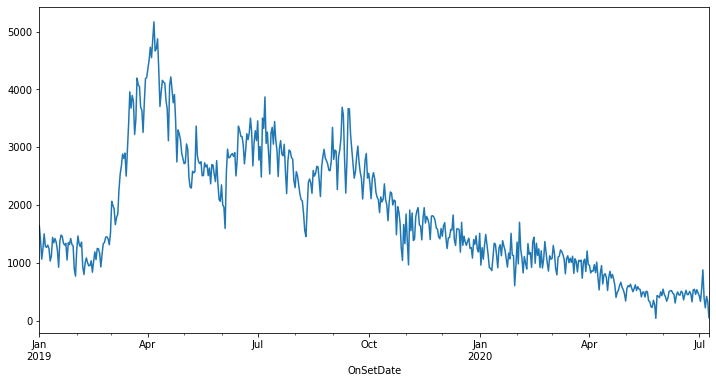

In [7]:
df['Cholera suspected cases'].plot(figsize=(12,6));

Text(0.5, 1.0, 'autocovariance, nlag=14')

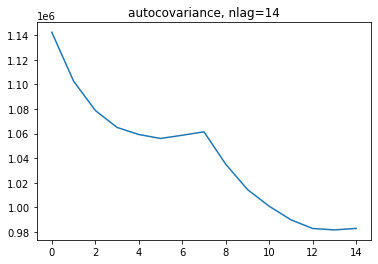

In [8]:
plt.plot(stattools.acovf(df['Cholera suspected cases'], fft=True, nlag=14));
plt.title('autocovariance, nlag=14')

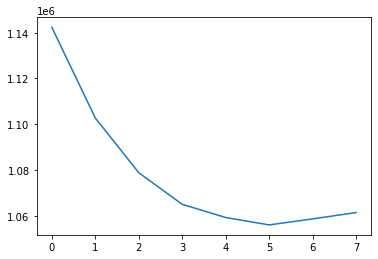

In [ ]:
plt.plot(stattools.acovf(df['Cholera suspected cases'], fft=True, nlag=7));

Text(0.5, 1.0, 'after gaussian filter')

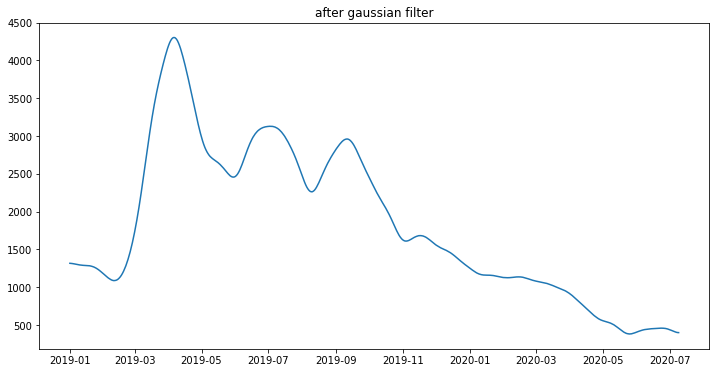

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.OnSetDate, gaussian_filter(df['Cholera suspected cases'], 7))
plt.title('after gaussian filter')

# modelling

In [1]:
def cholera_ode(z, t, beta, gamma, mu, kappa, B):
    S, I, R = z
    N = S + I + R
    lamb = beta * (B / (B + kappa))

    dSdt = - lamb * S + N - S
    dIdt = lamb * S - (gamma + mu) * I 
    dRdt = gamma * I - R

    #dBdt = xi * I - delta * B

    return [dSdt, dIdt, dRdt]


In [ ]:
def ode_solver(t, initial_conditions, params):
    initS, initI, initR = initial_conditions
    beta, gamma, mu, kappa, B = params
    res = odeint(cholera_ode, [initS, initI, initR], t, args=(beta, gamma, mu, kappa, B))
    return res

In [ ]:
cases = gaussian_filter(df['Cholera suspected cases'], 7)
deaths = np.nan_to_num(df['Cholera deaths'].values, 0)

initI = cases[0]
initR = deaths[0]
initS = 534000 - initI - initR

B = 10
beta = 1e-5             # rate of contact with reservoir  water
gamma = 1 / 5           # duration of infection
delta = 4.29            # cholera life span in water reservoir
xi = 10                 # rate of water contamination by humans
kappa = 1 / 1e+5        # concentration of cholera that yields 50% chance of infection
mu = (2.9 * 10 ** (-5)) # death rate due to cholera

days = len(cases)

initial_conditions = [initS, initI, initR]
params = [beta, gamma, mu, kappa, B]
tspan = np.arange(0, 556, 1)

In [ ]:
def mnk(x):
    sol = ode_solver(tspan, initial_conditions, x)
    S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]
    diff_I = sum([(cases[i] - I[i])**2 for i in range(len(tspan))])
    return diff_I 

res2 = minimize(mnk, params)

In [ ]:
for i in res2.x:
    print(round(i, 4))

0.0003
-1.5312
1.54
2.5119
0.8157


In [ ]:
sol = odeint(cholera_ode, initial_conditions, tspan, args=tuple(res2.x))
S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]
r2_score(cases, I)

0.8064761075431894

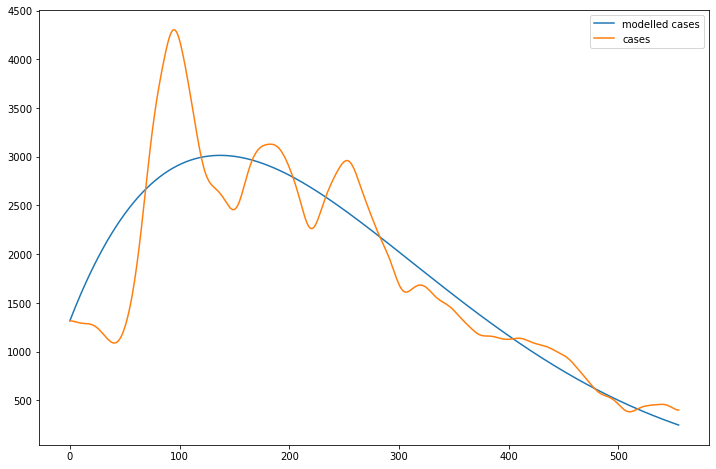

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(tspan, I, label='modelled cases')
plt.plot(tspan, cases, label='cases')
plt.legend();

# arima

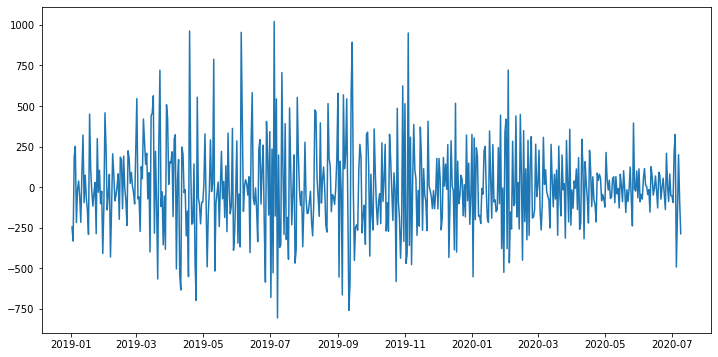

In [ ]:
by_week = df['Cholera suspected cases']#.resample('W').sum()
dif_cases = by_week.diff(periods=1).dropna()
plt.figure(figsize=(12, 6))
plt.plot(dif_cases);

In [ ]:
test = sm.tsa.adfuller(dif_cases)
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

единичных корней нет, ряд стационарен


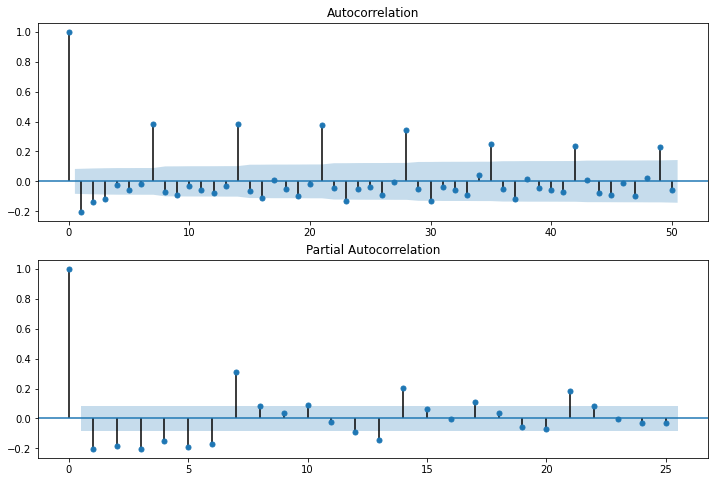

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif_cases.values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dif_cases, lags=25, ax=ax2)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(by_week, order=(50, 1, 2), 
                ).fit(disp=-1)

Text(0.5, 1.0, 'residuals')

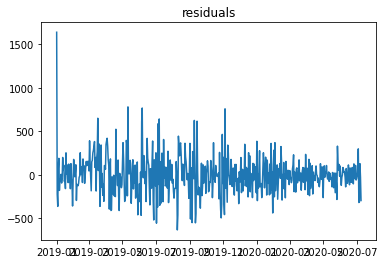

In [ ]:
plt.plot(model.resid)
plt.title('residuals')

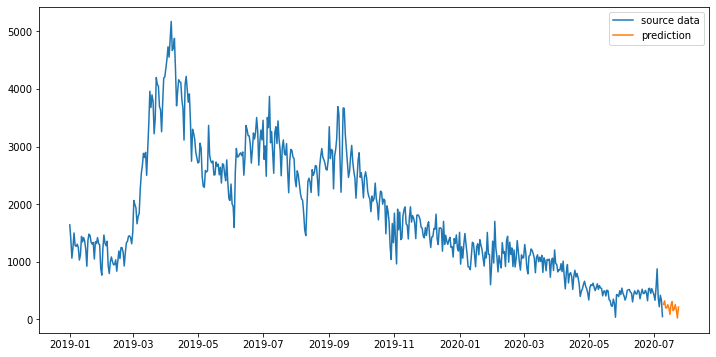

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(by_week,  label='source data')
plt.plot(model.predict(start=by_week.shape[0], end = by_week.shape[0]+14), label='prediction')
plt.legend()

# Results

In [ ]:
pred_tspan = np.arange(0, 600, 1)
sol = ode_solver(pred_tspan, initial_conditions, res2.x)
S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]

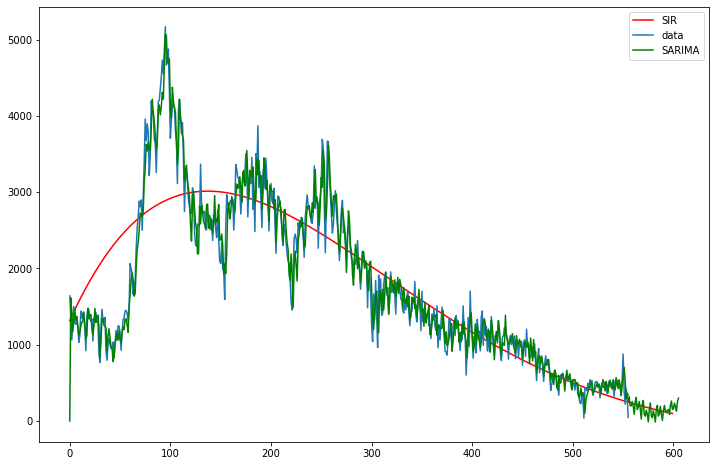

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(pred_tspan, I, 'r', label='SIR')
plt.plot(tspan, by_week, label='data')
plt.plot(list(range(len(model.fittedvalues))), model.fittedvalues, 'g', label='SARIMA')
plt.plot(list(range(555, len(model.fittedvalues)+50)), model.predict(start=by_week.shape[0], end = by_week.shape[0]+50), 'g')
plt.legend();